<a href="https://colab.research.google.com/github/Zheng7426/machine_learning_practice/blob/master/housePrice_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [13]:
train_data.shape

(404, 13)

<b>Feature-wise Normalization</b>

In [0]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

<b>Model Definition</b>

In [0]:
from keras import models
from keras import layers

def build_model():
  model = models.Sequential()
  model.add(layers.Dense(64, activation='relu', 
                         input_shape=(train_data.shape[1],)))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(1))
  model.compile(optimizer="rmsprop",
                loss="mse",
                metrics=['mae'])
  return model

In [16]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
  print('processing fold number', i)
  val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

  partial_train_data = np.concatenate(
      [train_data[:i * num_val_samples], 
       train_data[(i + 1) * num_val_samples:]], 
       axis=0
  )

  partial_train_target = np.concatenate(
      [train_targets[:i * num_val_samples],
       train_targets[(i + 1) * num_val_samples:]],
       axis=0
  )

  model = build_model()
  model.fit(partial_train_data, partial_train_target,
            epochs=num_epochs, batch_size=1, verbose=0)
  val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
  all_scores.append(val_mae)

processing fold number 0
processing fold number 1
processing fold number 2
processing fold number 3


In [17]:
all_scores

[2.8994150161743164,
 3.0659730434417725,
 2.5412702560424805,
 2.4531664848327637]

In [18]:
np.mean(all_scores)

2.7399562001228333

<b>Saving he validation logs at each fold</b>

In [25]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
  print('processing fold #', i)
  val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

  partial_train_data = np.concatenate(
      [train_data[:i * num_val_samples], 
       train_data[(i + 1) * num_val_samples:]],
       axis=0
  )

  partial_train_target = np.concatenate(
      [train_targets[:i * num_val_samples], 
       train_targets[(i + 1) * num_val_samples:]],
       axis=0
  )

  model = build_model()
  history = model.fit(partial_train_data, partial_train_target,
                      validation_data = (val_data, val_targets), 
                      epochs=num_epochs, 
                      batch_size=1, 
                      verbose=0)
  history_dict = history.history
  #print(history_dict.keys())
  mae_history = history.history['val_mae']
  all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [0]:
average_mae_history = [
                       np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]


In [32]:
print(len(average_mae_history))
print(len(all_mae_histories[0]))

500
500


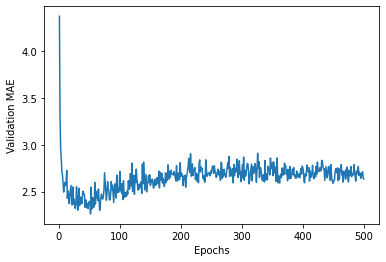

In [33]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

Exclude the first 10 data points as they are on a different scale than the rest of the curve.

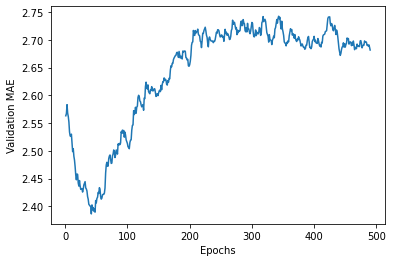

In [34]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [35]:
model = build_model()
model.fit(train_data, train_targets, 
          epochs=80, 
          batch_size=16,
          verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 207us/step


In [36]:
print("mse: ", test_mse_score)
print("mae: ", test_mae_score)

mse:  19.570546168907015
mae:  2.847848892211914


In [37]:
predictions = model.predict(test_data)
predictions[0]

array([9.230533], dtype=float32)

In [39]:
test_targets[0]

7.2